Neste notebook iremos **pré-processar os dados** e **exporta-los** em formato *.pkle* (*pickle*) para posterior treinamento do modelo, ou seja:
- A partir do json *carros_rotulados.json*, adquirir os valores **x,y,width e height** das posições dos carros em cada imagem.
- Criar dois arrays, onde em um terá as imagens e no outro o array de posições dos carros em cada imagem. (x,y,w e h).
- Redimensionar as imagens para um tamanho fixo.
- Normalizar os valores dos pixels para o intervalo de 0 a 1.

Foi realizado a rotulagem de 10 imagens com 5 rótulos cada.
- Necessário ser a mesma quantidade de rótulos para cada imagem para funcionar corretamente no Keras.

In [270]:
import json
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

**Importante:**

O Label Studio fornece coordenadas relativas à imagem original, onde:
- x, y representam a posição superior esquerda da caixa como **porcentagem** do tamanho da imagem original.
- w, h representam a largura e altura caixa como **porcentagem** do tamanho da imagem original.

Para ter os valores absolutos de x, y, w e h é necessário realizar a seguinte conversão:

```python
x_abs = x * original_width / 100
y_abs = y * original_height / 100
w_abs = w * original_width / 100
h_abs = h * original_height / 100
```

In [271]:
def load_data(path: str, resized = (128,128)):
    images = []
    labels = []
    original_images = []
    original_labels = []
    new_width, new_height = resized

    # Abre e lê o arquivo json
    with open(path, 'r') as f:
        data = json.load(f)
    
    # Itera sobre o array do json
    for item in data:
        # Adquire o caminho da imagem (split para remover o id inicial gerado pelo labelStudio e adquirir o nome real)
        image_path = item['file_upload'].split('-',1)[1]
        image_path = os.path.join('train_images', image_path)
        
        # Lê a imagem e em seguida converte para escala de cinza
        original_img = cv2.imread(image_path)
        img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        
        original_h, original_w = img.shape
        # Redimensiona a imagem sem perder a proporção com interpolação
        img = cv2.resize(img, (new_width, new_height),
                         interpolation=cv2.INTER_LANCZOS4)
        
        # Adiciona 1 canal para o keras interpretar corretamente, ou seja de (128, 128) ficará (128,128,1)
        img = np.expand_dims(img, axis=-1)
        
        # Itera sobre as anotações da imagem atual
        label_boxes = []
        original_boxes = []
        for annotation in item['annotations']:
            for result in annotation['result']:
                value = result['value']
                x, y, w, h = value['x'], value['y'], value['width'], value['height']
                
                # Para as coordenadas originais é necessário fazer uma conversão, pois o Label Studio fornece coordenadas relativas à imagem original
                x = x * original_w / 100
                y = y * original_h / 100
                w = w * original_w / 100
                h = h * original_h / 100
                
                # Ajusta a caixa delimitadora com as mesmas proporporções do redimensionamento
                x_ratio = (new_width / original_w)
                y_ratio = (new_height / original_h)

                coords = [
                    (x * x_ratio),
                    (y * y_ratio),
                    (w * x_ratio),
                    (h * y_ratio)
                ]

                original_coords = [
                    x,
                    y,
                    w,
                    h
                ]
                
                label_boxes.append(coords)
                original_boxes.append(original_coords)

        # Converte a imagem original de BGR para RGB
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Adiciona imagem e labels no array
        images.append(img)
        labels.append(label_boxes)
        original_images.append(original_img)
        original_labels.append(original_boxes)

    # Converte para array numpy e normaliza as imagens para o intervalo de 0 a 1
    images = np.array(images, dtype='float32') / 255.0

    #'dtype object' para não dar erro em caso de array não homogeneo (com dimensões diferentes)
    labels = np.array(labels, dtype='float32')

    # Padroniza as labels para o formato [numero_imagens, 5*4]
    labels = labels.reshape((labels.shape[0], -1))
        
    return images, labels, original_images, original_labels

In [272]:
images, labels, original_images, original_labels = load_data('carros_rotulados.json')

In [273]:
# Salva os dados em um arquivo binário, a variável 'f' representa o objeto do arquivo aberto
with open('cars.pkl', 'wb') as f: # wb (write binary) irá criar o arquivo caso não exista, caso exista irá sobrescrever
    pickle.dump((images, labels), f)

print('Dados de carros salvos com pickle.')

Dados de carros salvos com pickle.


**Visualização dos dados rotulados**

In [274]:
# Função para desenhar as caixas
def draw_boxes(img, boxes, thickness = 2):
    img_copy = img.copy()

    for box in boxes:
        x, y, w, h = box

        cv2.rectangle(img_copy, (int(x), int(y)), (int(x+w), int(y+h)),
                      color=(255,255,0),
                      thickness=thickness)
    
    return img_copy

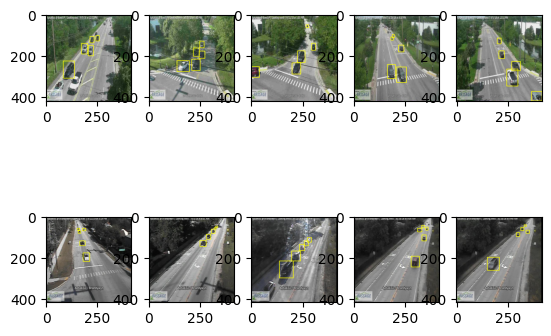

In [275]:
index = 0
for img in original_images:
    img = draw_boxes(img, original_labels[index])

    plt.subplot(2,5, index+1)
    plt.imshow(img)
    index += 1

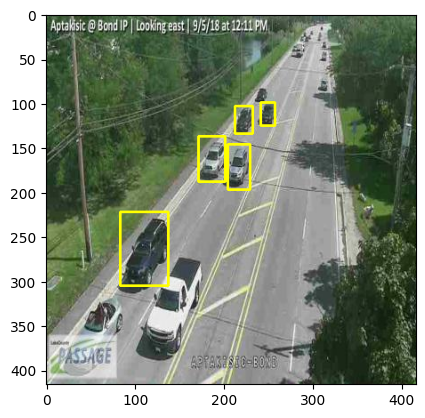

In [276]:
img = draw_boxes(original_images[0], original_labels[0])
plt.imshow(img)

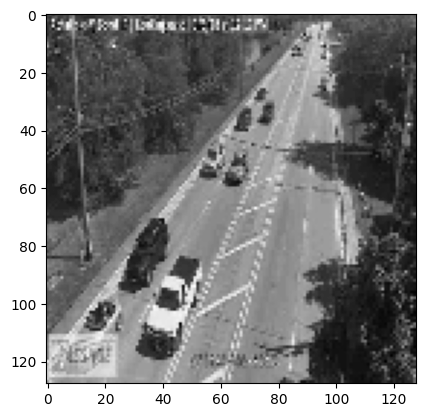

In [277]:
# Squeeze remove a dimensão extra o número 1 da dimensão: (128,128,1)
img_squeezed = np.squeeze(images[0])
resized_boxes = labels[0].reshape(-1, 4)

img_label = draw_boxes(img_squeezed, resized_boxes, 1)

plt.imshow(img_squeezed, cmap='gray') # Não aparece o label (?)